In [1]:
import warnings 
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy import ndimage
import cv2

In [2]:
meta = pd.read_csv("/kaggle/input/glaucoma-detection/glaucoma.csv")
meta

,Filename,ExpCDR,Eye,Set,Glaucoma
0,001.jpg,0.7097,OD,A,0
1,002.jpg,0.6953,OS,A,0
2,003.jpg,0.9629,OS,A,0
3,004.jpg,0.7246,OD,A,0
4,005.jpg,0.6138,OS,A,0
...,...,...,...,...,...
645,646.jpg,0.6560,OD,A,1
646,647.jpg,0.7365,OD,A,1
647,648.jpg,0.5101,OS,A,1
648,649.jpg,0.5227,OD,B,0


In [3]:
meta["Glaucoma"].value_counts()

Glaucoma
0    482
1    168
Name: count, dtype: int64

In [3]:
all_images = glob("/kaggle/input/glaucoma-detection/ORIGA/ORIGA/Images/*.jpg")
root = "/kaggle/input/glaucoma-detection/ORIGA/ORIGA/Images"
meta["Path"] = meta["Filename"].apply(lambda fn: os.path.join(root, fn))
meta.head()

,Filename,ExpCDR,Eye,Set,Glaucoma,Path
0,001.jpg,0.7097,OD,A,0,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/I...
1,002.jpg,0.6953,OS,A,0,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/I...
2,003.jpg,0.9629,OS,A,0,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/I...
3,004.jpg,0.7246,OD,A,0,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/I...
4,005.jpg,0.6138,OS,A,0,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/I...


In [6]:
meta.groupby("Glaucoma")["ExpCDR"].mean()

Glaucoma
0    0.542243
1    0.674040
Name: ExpCDR, dtype: float64

### Visualize Fondus Images

(3072, 2048)


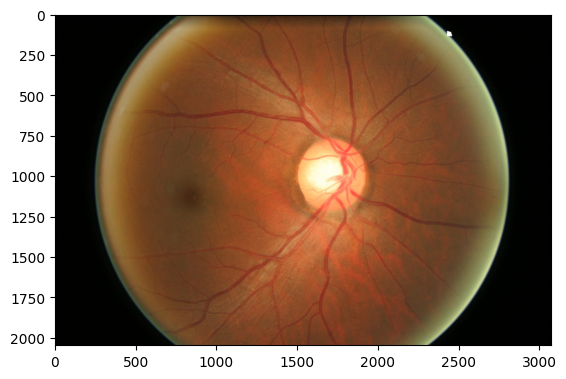

In [6]:
image = Image.open(all_images[0])
print(image.size)
plt.imshow(image)

In [4]:
def gamma_correct(img, gamma=0.4):
    img = img.astype(np.uint8)
    lookUpTable = np.empty((1,256), np.uint8)

    for i in range(256):
        lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
    out = cv2.LUT(img, lookUpTable)
    return out

def clahe(image, cl=2.0, tgs=8):
    clahe = cv2.createCLAHE(clipLimit=cl, tileGridSize=(tgs, tgs))
    cl1 = clahe.apply(image)
    return cl1

def clahe_rgb(img, cl=2.0, tgs=8):
    g, b, r = cv2.split(img)
    g, b, r = clahe(g), clahe(b), clahe(r)
    return cv2.merge([g, b, r])

def apply_gaussian(img):
    img = cv2.GaussianBlur(img, (5,5), 0)
    return img 

def get_bounding_box(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    return [x, y, w, h]

def remove_black_padding(img, threshold):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, th = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
    
    # finding the biggest box and it's corresponding bboxes
    x, y, w, h = get_bounding_box(th)
    
    c_size = 300
    final_size = 384
    
    images = []

    for i, image in enumerate([clahe(gray), gamma_correct(gray, 3), clahe_rgb(img), img]):
        
        # removing empty padding and noninformative parts
        crop = image[y+c_size:y+h-c_size, x+c_size:x+w-c_size]
        
        # resizing to the final size
        crop_resized = cv2.resize(crop, (final_size, final_size))
        
        if i == 2:
            images.append(crop)
            
        images.append(crop_resized)
        
    return images

def crop_cup_disc(img, mask):
    x, y, w, h = get_bounding_box(mask)
    width_ratio = img.shape[1]/mask.shape[1]
    height_ratio = img.shape[0]/mask.shape[0]
    x, w = int(x * width_ratio), int(w * width_ratio)
    y, h = int(y * height_ratio), int(h * height_ratio)
    
    # Estimated center of the disc
    cx = x + w//2
    cy = y + h//2
    
    # Cropping a 500 * 500 image that contains the disc
    c_size = 300
    x_start = (cx-c_size) if (cx > c_size) else 0
    y_start = (cy-c_size) if (cy > c_size) else 0
    crop = img[y_start:cy+c_size, x_start:cx+c_size]
    
    # Resizing to the final size
    final_size = 384
    crop = cv2.resize(crop, (final_size, final_size))

    return crop

In [5]:
def ensure_cluster_groups(data_2d, labels, clusters=4):
    # ensuring the clusters order
    mean_intensities = [data_2d[labels == i].mean() for i in range(clusters)]
    label_map = {i: label for i, label in sorted(enumerate(mean_intensities), key=lambda x: x[1])}
    label_map = {k: i for i, k in enumerate(label_map.keys())}
    mapped_labels = np.vectorize(label_map.get)(labels)
    return mapped_labels

def cluster_image(img):
    slc_image = img

    # clustering
    data_2d = img.reshape(-1, 1)
    kmeans = KMeans(n_clusters=6, n_init=3, random_state=0).fit(data_2d)

    # Reshape the labels back to original shape
    labels = kmeans.labels_
    labels = ensure_cluster_groups(data_2d, labels, 6)
    labels = labels.reshape(img.shape)

    # Create a binary mask by thresholding the brain intensity
    mask = np.isin(labels, [4, 5])
    mask = (mask * 255).astype(np.uint8)

    return mask

In [6]:
def apply_morphology(binary_mask):
    kernel = np.ones((5,5),np.uint8)
    opening = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel, iterations = 1)
    
    kernel = np.ones((5,5),np.uint8)
    final = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations = 2)
    
    return final

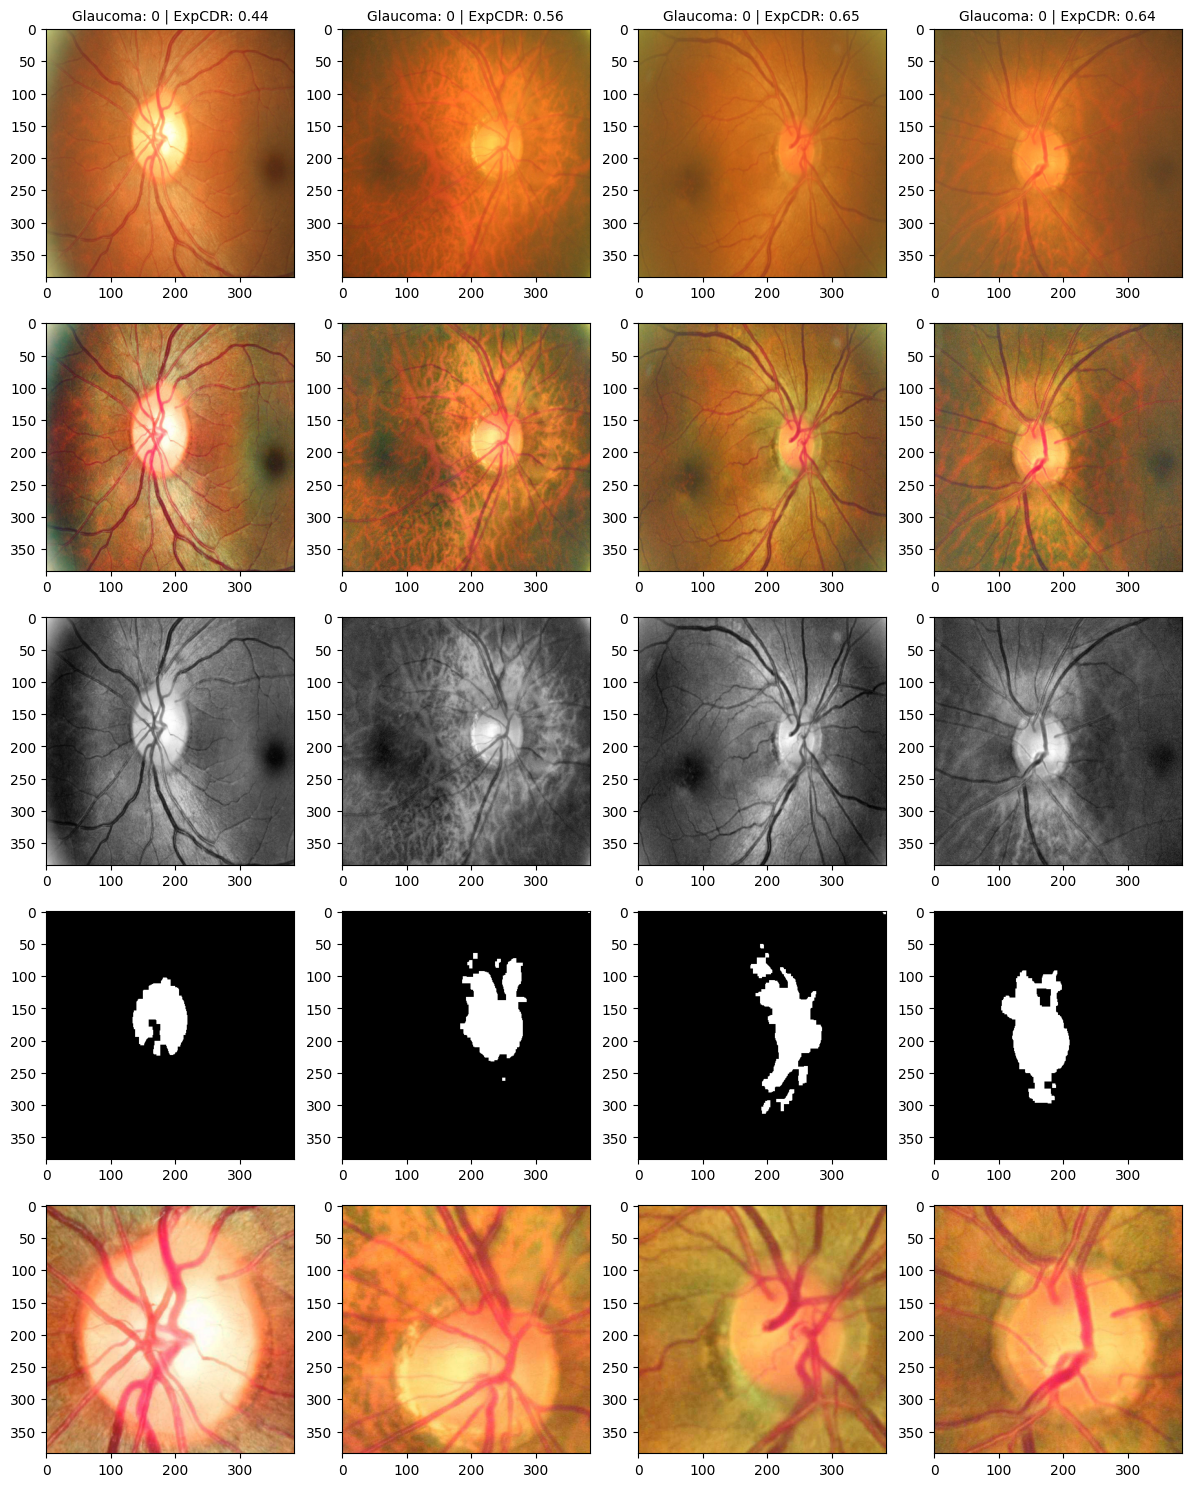

In [7]:
fig, axs = plt.subplots(5, 4, figsize=(12, 15))

for i in range(4):
    path = all_images[160 + i]
    
    # Finding Glaucoma Dx and ExpCDR
    file_name = Path(path).parts[-1]
    row = meta.loc[meta["Filename"] == file_name].iloc[0]
    gl, exp_cdr = row["Glaucoma"], row["ExpCDR"]
    
    img = cv2.imread(path)
    clahe_gray, corrected_gray, rgb_clahe_org, rgb_clahe_cropped, rgb_cropped = remove_black_padding(img, 10)
    
    # Segmenting the disc
    segmented = cluster_image(corrected_gray)
    segmented = apply_morphology(segmented)
    
    rgb_cup = crop_cup_disc(rgb_clahe_org, segmented)
    
    axs[0, i].imshow(rgb_cropped[..., ::-1])
    axs[0, i].set_title(f"Glaucoma: {gl} | ExpCDR: {exp_cdr:0.2f}", fontsize=10)
    axs[1, i].imshow(rgb_clahe_cropped[..., ::-1])
    axs[2, i].imshow(clahe_gray, cmap='gray')
    axs[3, i].imshow(segmented, cmap='gray')
    axs[4, i].imshow(rgb_cup[..., ::-1])
    
plt.tight_layout()
plt.show()

### Save cropped images

In [8]:
from tqdm import tqdm
import os

save_path = "/kaggle/working/cropped_images"
if not os.path.exists(save_path):
    os.makedirs(save_path)
    
for image_path in tqdm(all_images):
    image_name = Path(image_path).parts[-1]
    
    new_path = os.path.join(save_path, image_name)
    
    img = cv2.imread(image_path)
    _, corrected_gray, rgb_clahe_org, _, _ = remove_black_padding(img, 10)
    
    # Segmenting the disc
    segmented = cluster_image(corrected_gray)
    segmented = apply_morphology(segmented)
    
    rgb_cup = crop_cup_disc(rgb_clahe_org, segmented)
    
    cv2.imwrite(new_path, rgb_cup)

100%|██████████| 650/650 [03:59<00:00,  2.72it/s]


In [9]:
save_path = "/kaggle/working/cropped_images"
meta_gl = meta.loc[meta["Glaucoma"] == 0]
meta_nl = meta.loc[meta["Glaucoma"] == 1]
new_meta = pd.concat([meta_gl.iloc[:170], meta_nl]).copy()

In [30]:
print(new_meta.head)

<bound method NDFrame.head of     Filename  ExpCDR Eye Set  Glaucoma  \
0    001.jpg  0.7097  OD   A         0   
1    002.jpg  0.6953  OS   A         0   
2    003.jpg  0.9629  OS   A         0   
3    004.jpg  0.7246  OD   A         0   
4    005.jpg  0.6138  OS   A         0   
..       ...     ...  ..  ..       ...   
644  645.jpg  0.7111  OS   A         1   
645  646.jpg  0.6560  OD   A         1   
646  647.jpg  0.7365  OD   A         1   
647  648.jpg  0.5101  OS   A         1   
649  650.jpg  0.6195  OS   B         1   

                                                            Path  
0    /kaggle/input/glaucoma-detection/ORIGA/ORIGA/Images/001.jpg  
1    /kaggle/input/glaucoma-detection/ORIGA/ORIGA/Images/002.jpg  
2    /kaggle/input/glaucoma-detection/ORIGA/ORIGA/Images/003.jpg  
3    /kaggle/input/glaucoma-detection/ORIGA/ORIGA/Images/004.jpg  
4    /kaggle/input/glaucoma-detection/ORIGA/ORIGA/Images/005.jpg  
..                                                           ..

# Preparing data for model training and testing

In [11]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(new_meta, test_size=0.25, random_state=0)
print(train_df.shape, test_df.shape)

(253, 6) (85, 6)


In [12]:
from torch.utils.data import Dataset, DataLoader
import torch
from PIL import Image

class GlaucomaDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform
        self.data = self.get_data()
    
    def get_data(self):
        data = []
        for i, row in self.df.iterrows():
            label = row["Glaucoma"]
            exp_cdr = row["ExpCDR"]
            name = Path(row["Path"]).parts[-1]
            path = os.path.join(save_path, name)
            data.append(((path, exp_cdr), label))
        return data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        (img_path, exp_cdr), label = self.data[idx]
        image = Image.open(img_path)
        image = self.transform(image)
        return (image, torch.FloatTensor([exp_cdr])), label

from torchvision import transforms

train_transforms = transforms.Compose([
    #transforms.Resize((224, 224), antialias=True),
    transforms.RandomApply([transforms.RandomHorizontalFlip()], p=0.2),
    transforms.RandomApply([transforms.RandomVerticalFlip()], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define the transformations for the test dataset
test_transforms = transforms.Compose([
    #transforms.Resize((224, 224), antialias=True),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [13]:
train_data = GlaucomaDataset(train_df, train_transforms)
test_data = GlaucomaDataset(test_df, test_transforms)
b_size = 16
train_loader = DataLoader(train_data, batch_size=b_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=b_size, shuffle=False)

In [23]:
one_batch = next(iter(train_loader))

### Visualize a batch

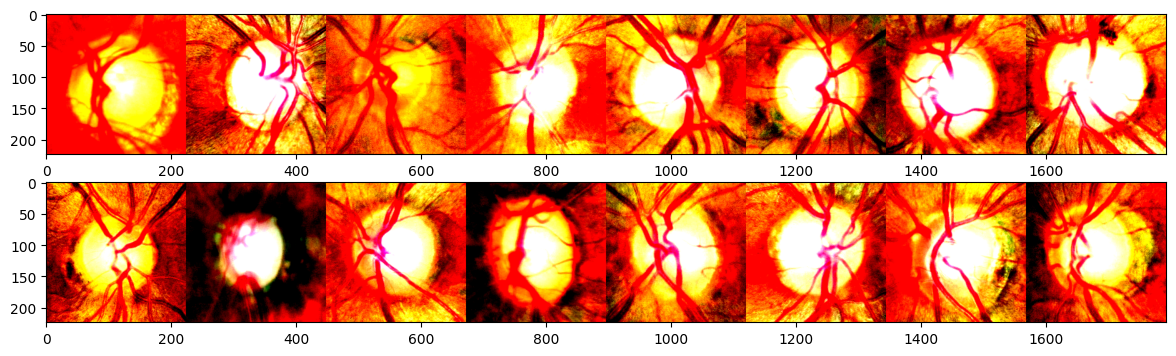

In [24]:
batch_imgs = one_batch[0][0].numpy()
rows = 2
fig, axs = plt.subplots(rows, 1, figsize=(16, 4))
for i in range(rows):
    img = np.hstack([batch_imgs[j].transpose(1, 2, 0) for j in range(i * (b_size//rows), (b_size//rows) * (i+1))])
    axs[i].imshow(img)
plt.show()

# Model

In [24]:
import torch
from torch import nn
from torchvision import models
import torchvision.models as models

class CombinedModel1(nn.Module):
    def __init__(self):
        super().__init__()

        # 加载 ResNet-50，并指定 weights 参数
        # models.ResNet50_Weights.IMAGENET1K_V1 表示加载 ImageNet 上的预训练权重
        self.cnn_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        
        # 然后像之前解释的那样，进行参数冻结和分类层替换：
        for param in self.cnn_model.parameters():
            param.requires_grad = False
            
        # 替换最后一层 fc，使其输出 30 个特征
        num_features = self.cnn_model.fc.in_features
        self.cnn_model.fc = nn.Linear(num_features, 30)
        # 注意：新创建的 nn.Linear 层的参数默认是 requires_grad=True，因此它不会被冻结，可以正常训练。
        
        # Feed-forward network for numerical data
        self.ff_model = nn.Sequential(
            nn.Linear(1, 16),  # Assume numerical input has 1 feature
            nn.ReLU(),
            nn.Linear(16, 2)
        )
        print(num_features)
        #self.ff_model.to("cuda:0")
        
        # Final layers
        self.final_layers = nn.Sequential(
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Linear(8, 2)  # Assume binary classification
        )

    def forward(self, *x):
        image, exp_cdr = x[0]
        x1 = self.cnn_model(image)
        x2 = self.ff_model(exp_cdr)
        x = torch.cat((x1, x2), dim=1)
        x = self.final_layers(x)
        return x

In [26]:
#怀疑模型并未分析图像，而只是靠expCDR. 假如不用expCDR
#结论：效果也不错, 相差不大
import torch
from torch import nn
from torchvision import models
import torchvision.models as models

class CombinedModel2(nn.Module):
    def __init__(self):
        super().__init__()

        # 加载 ResNet-50，并指定 weights 参数
        # models.ResNet50_Weights.IMAGENET1K_V1 表示加载 ImageNet 上的预训练权重
        self.cnn_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        
        # 然后像之前解释的那样，进行参数冻结和分类层替换：
        for param in self.cnn_model.parameters():
            param.requires_grad = False
            
        # 替换最后一层 fc，使其输出 30 个特征
        num_features = self.cnn_model.fc.in_features
        self.cnn_model.fc = nn.Linear(num_features, 30)
        # 注意：新创建的 nn.Linear 层的参数默认是 requires_grad=True，因此它不会被冻结，可以正常训练。
        
        # # Feed-forward network for numerical data
        # self.ff_model = nn.Sequential(
        #     nn.Linear(1, 16),  # Assume numerical input has 1 feature
        #     nn.ReLU(),
        #     nn.Linear(16, 2)
        # )
        
        #self.ff_model.to("cuda:0")
        
        # Final layers
        self.final_layers = nn.Sequential(
            nn.Linear(30, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )

    def forward(self, *x):
        image, exp_cdr = x[0]
        x1 = self.cnn_model(image)
        x = self.final_layers(x1)
        return x

In [31]:
#试试别的预训练模型
import torch
from torch import nn
import timm

class CombinedModel3(nn.Module):
    def __init__(self):
        super().__init__()
        # 使用 EfficientNet-b0 (或者 b3/b4)
        self.cnn_model = timm.create_model('efficientnet_b3', pretrained=True, num_classes=0) 
        # num_classes=0 会移除最后的分类层，直接输出特征
        
        num_features = self.cnn_model.num_features

        # --- 2. CNN 特征投影层 (新增) ---
        # 将高维的 EfficientNet 特征降维到 30，以匹配您之前的架构设计。
        # 加入了 ReLU 和 Dropout 以增加非线性和防止过拟合。
        self.cnn_projection = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 30)  # 最终输出 30 个特征给下一层
        )
        # Feed-forward network for numerical data
        self.ff_model = nn.Sequential(
            nn.Linear(1, 16),  # Assume numerical input has 1 feature
            nn.ReLU(),
            nn.Linear(16, 2)
        )
        
        #self.ff_model.to("cuda:0")
        
        # Final layers
        self.final_layers = nn.Sequential(
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Linear(8, 2)  # Assume binary classification
        )

    def forward(self, *x):
        image, exp_cdr = x[0]
        x1 = self.cnn_model(image)
        x1 = self.cnn_projection(x1)
        x2 = self.ff_model(exp_cdr)
        x = torch.cat((x1, x2), dim=1)
        x = self.final_layers(x)
        return x

In [26]:
#ConvNeXt,DenseNet,regnet效果不如Resnet, 分辨率上384 > 244 > 512
import timm
import torch.nn as nn
import torch

class CombinedModel4(nn.Module):
    def __init__(self, model_name='regnety_002'):
        super().__init__()
        
        print(f"Loading {model_name}...")
        # num_classes=0 移除原本的分类头，只保留特征提取器
        self.cnn_model = timm.create_model(model_name, pretrained=True, num_classes=0)
        
        # 获取 RegNetY 的输出特征维度
        # regnety_040 的输出通常是 1088 维
        num_features = self.cnn_model.num_features
        print(f"Feature Num: {num_features}")

        # 投影层：将高维特征压缩到 30 维
        # RegNetY 的特征比较“紧凑”，我们加一个 LayerNorm 帮助稳定
        self.cnn_projection = nn.Linear(num_features, 30)
        
        # FFN (ExpCDR) 部分保持不变
        self.ff_model = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
        )
        
        # 最终分类层
        self.final_layers = nn.Sequential(
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )

    def forward(self, *x):
        image, exp_cdr = x[0]
        
        # 1. CNN 特征提取
        features = self.cnn_model(image)
        x1 = self.cnn_projection(features)
        
        # 2. 数值特征提取
        x2 = self.ff_model(exp_cdr)
        
        # 3. 拼接与分类
        x = torch.cat((x1, x2), dim=1)
        x = self.final_layers(x)
        return x

In [27]:
model = CombinedModel4()
#model = model.to("cuda:0")

Loading regnety_002...
Feature Num: 368


In [28]:
#这个版本不需要手动冻结参数
from fastai.vision.all import *
# 确保引入 LabelSmoothingCrossEntropy，这在医学图像中通常比普通交叉熵更好
from fastai.losses import LabelSmoothingCrossEntropy
from fastai.metrics import accuracy, Recall, Precision, F1Score, RocAucBinary

# 重新定义 Learner
# 建议使用 LabelSmoothingCrossEntropy 提高泛化能力
learner = Learner(DataLoaders(train_loader, test_loader), model,
                  metrics=[accuracy, Recall(), Precision(), F1Score(), RocAucBinary()],
                  loss_func=LabelSmoothingCrossEntropy())

# 定义回调函数 (保持不变)
save_best = SaveModelCallback(
    monitor='f1_score',
    fname='best_efficientnet_glaucoma', # 更改保存的文件名以示区别
)

# 早停耐心值可以稍微增加一点，因为微调需要一些时间来适应
early_stop = EarlyStoppingCallback(
    monitor='f1_score', 
    min_delta=0.005,      
    patience=15
)

print("开始微调训练...")
# --- 使用 fine_tune 进行两阶段训练 ---
# 阶段 1: 冻结 EfficientNet 主干，只训练自定义的头部 (cnn_projection, ff_model, final_layers) 运行 3 个 epoch。
# 阶段 2: 解冻所有层，使用较低的学习率训练 50 个 epoch (受早停控制)。
# base_lr: 这是第二阶段的最大学习率。第一阶段的学习率默认是它的 1/10。
learner.fine_tune(
    epochs=50,          # 解冻后训练的最大轮数
    base_lr=1e-3,       # 基础学习率
    freeze_epochs=3,    # 冻结训练的轮数
    cbs=[early_stop, save_best]
)

开始微调训练...


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.695439,0.683881,0.447059,1.000000,0.447059,0.617886,0.740202,00:30
1,0.631914,0.615731,0.670588,0.842105,0.592593,0.695652,0.843785,00:32
2,0.558099,0.598977,0.764706,0.710526,0.750000,0.729730,0.856103,00:29


Better model found at epoch 0 with f1_score value: 0.6178861788617886.
Better model found at epoch 1 with f1_score value: 0.6956521739130435.
Better model found at epoch 2 with f1_score value: 0.7297297297297298.


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.317515,0.568278,0.776471,0.789474,0.731707,0.759494,0.874020,00:33
1,0.300691,0.572233,0.729412,0.763158,0.674419,0.716049,0.862262,00:33
2,0.280674,0.575474,0.776471,0.789474,0.731707,0.759494,0.863382,00:30
3,0.267144,0.632703,0.752941,0.894737,0.666667,0.764045,0.848264,00:32
4,0.264587,0.622623,0.764706,0.921053,0.673077,0.777778,0.868981,00:31
5,0.253780,0.663737,0.705882,0.736842,0.651163,0.691358,0.848264,00:34
6,0.250359,0.611404,0.729412,0.763158,0.674419,0.716049,0.847144,00:38
7,0.252966,0.628404,0.729412,0.763158,0.674419,0.716049,0.850504,00:32
8,0.255279,0.732192,0.717647,0.842105,0.640000,0.727273,0.813550,00:30
9,0.249806,0.622289,0.741176,0.894737,0.653846,0.755556,0.888018,00:30


Better model found at epoch 0 with f1_score value: 0.7594936708860759.
Better model found at epoch 3 with f1_score value: 0.7640449438202247.
Better model found at epoch 4 with f1_score value: 0.7777777777777778.
Better model found at epoch 17 with f1_score value: 0.782608695652174.
No improvement since epoch 4: early stopping


In [58]:
from fastai.vision.all import *
from fastai.vision import *

from fastai.metrics import accuracy, Recall, Precision, F1Score, RocAucBinary

learner = Learner(DataLoaders(train_loader, test_loader), model,
                  metrics=[accuracy, Recall(), Precision(), F1Score(), RocAucBinary()],
                  loss_func=CrossEntropyLossFlat())

# 定义保存模型的回调函数
save_best = SaveModelCallback(
    monitor='f1_score',  # 监控 F1 Score（或者您最关心的指标，如 valid_loss 或 RocAucBinary）
    fname='best_glaucoma_model' # 模型文件的名称，将保存在 learner.path/models/ 目录下
)

early_stop = EarlyStoppingCallback(
    monitor='f1_score', # 监控的指标
    min_delta=0.01,       # 最小变化量，如果指标的变化小于此值，则认为没有改进
    patience=10          # 容忍度/耐心值，允许模型在没有改进的情况下运行的 epoch 数
)

# --- 使用早停进行训练 ---
learner.fit_one_cycle(
    n_epoch=100,             # 将 epoch 数量设置得大一些，让早停机制来决定何时停止
    lr_max=0.005,
    wd=1e-5,
    cbs=[early_stop,save_best]         # 将回调函数列表传递给 cbs 参数
)

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.698607,0.679677,0.670588,0.342105,0.812500,0.481481,0.716685,01:09
1,0.684047,0.670561,0.588235,0.842105,0.524590,0.646465,0.751400,01:08
2,0.668056,0.637675,0.682353,0.763158,0.617021,0.682353,0.760918,01:08
3,0.648544,0.635889,0.658824,0.815789,0.584906,0.681319,0.764838,01:08
4,0.621895,0.616612,0.670588,0.815789,0.596154,0.688889,0.777156,01:07
5,0.590854,0.586609,0.729412,0.789474,0.666667,0.722892,0.792273,01:07
6,0.558051,0.566094,0.717647,0.710526,0.675000,0.692308,0.806271,01:08
7,0.508823,0.608216,0.729412,0.736842,0.682927,0.708861,0.808511,01:08
8,0.462925,0.659457,0.694118,0.763158,0.630435,0.690476,0.804031,01:07
9,0.434340,0.611889,0.705882,0.421053,0.842105,0.561404,0.828108,01:08


Better model found at epoch 0 with f1_score value: 0.4814814814814815.
Better model found at epoch 1 with f1_score value: 0.6464646464646464.
Better model found at epoch 2 with f1_score value: 0.6823529411764706.
Better model found at epoch 4 with f1_score value: 0.6888888888888889.
Better model found at epoch 5 with f1_score value: 0.7228915662650601.
Better model found at epoch 11 with f1_score value: 0.7640449438202247.
Better model found at epoch 21 with f1_score value: 0.7816091954022989.
No improvement since epoch 21: early stopping


In [19]:
# 假设您在之前设置了保存文件名
MODEL_FNAME = 'best_efficientnet_glaucoma' 

# 确保 Learner 实例 (learner) 已经定义并可用。
# 如果您在新的环境中运行，需要重新定义模型和 Learner 实例。

# 载入最佳模型权重
# fastai 会在 learner.path/models/ 目录下查找名为 MODEL_FNAME 的文件
learner.load(MODEL_FNAME)

print(f"已成功载入模型权重：{learner.path}/models/{MODEL_FNAME}.pth")

# 使用 learner.validate() 方法进行评估
# 返回值是一个列表，第一个元素是损失值 (valid_loss)，后面是所有在 Learner 中定义的评估指标
results = learner.validate()

# 提取并打印结果
# 结果列表的结构对应于：[valid_loss, accuracy, recall, precision, f1_score, roc_auc_binary]
print("\n--- 验证集（Test Loader）评估结果 ---")
print(f"验证损失 (Valid Loss): {results[0]:.4f}")
print(f"准确率 (Accuracy): {results[1]:.4f}")
print(f"召回率 (Recall): {results[2]:.4f}")
print(f"精确率 (Precision): {results[3]:.4f}")
print(f"F1 分数 (F1 Score): {results[4]:.4f}")
print(f"ROC-AUC: {results[5]:.4f}")

# 注意：results 列表中指标的顺序取决于您定义 Learner 时 metrics=[...] 的顺序。
# 如果您使用了完整的 fastai 导入，上面的索引顺序应该是正确的。

已成功载入模型权重：./models/best_efficientnet_glaucoma.pth


# K-fold

In [ ]:
#f1_score Fold1:0.79 Fold2:0.81 Fold3:0.94 Fold4
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from fastai.vision.all import * 

# --- 1. 参数与数据准备 ---

# 假设你的所有数据都在这个 DataFrame 中，且包含 'label' 和 'path' 列
df = new_meta# 你的完整数据集 DataFrame 

N_SPLITS = 5  # K 值，通常使用 5 或 10
RANDOM_STATE = 42
all_fold_metrics = []

# 初始化 KFold 分割器。
# shuffle=True 非常重要，可以打乱数据后再分割。
# StratifiedKFold (分层K折) 更好，因为它能保证每个折叠的标签比例相似。
from sklearn.model_selection import StratifiedKFold 
kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)


# --- 2. K-Fold 训练主循环 ---

# kf.split() 返回的是数据的索引
for fold, (train_index, val_index) in enumerate(kf.split(df, df['Glaucoma'])):
    
    print(f"\n--- 🚀 Starting Fold {fold+1}/{N_SPLITS} ---")

    # A. 划分训练集和验证集的 DataFrame
    train_df = df.iloc[train_index].reset_index(drop=True)
    val_df = df.iloc[val_index].reset_index(drop=True)

    print(f"Fold {fold+1}: Train size={len(train_df)}, Validation size={len(val_df)}")

    # B. 创建数据集和数据加载器 (DataLoaders)
    # ⚠️ 注意：这里需要使用你的 GlaucomaDataset 类
    train_ds = GlaucomaDataset(train_df, train_transforms)
    val_ds = GlaucomaDataset(val_df, test_transforms)
    
    train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=16) 
    dls = DataLoaders(train_dl, val_dl)
    
    
    # C. 初始化新模型 (⚠️ 关键步骤！)
    # 每一折都必须重新实例化模型和 Learner，以确保权重是独立的。
    # 使用你当前效果最好的模型架构 (ResNet/EfficientNet)
    torch.cuda.empty_cache() # 清理显存，防止内存溢出
    model = CombinedModel3() # 重新创建模型实例
    model = model.to("cuda:0")
    
    # D. 设置 Learner 和回调函数
    # 使用你之前定义的指标、Loss和自定义回调 (如 CombinedMixUp)
    # 将模型文件名改为包含 fold 号，方便保存和加载
    learner = Learner(dls, model, 
                      metrics=[accuracy, Recall(), Precision(), F1Score(), RocAucBinary()],
                      loss_func=LabelSmoothingCrossEntropyFlat()
                    )
    
    save_cb = SaveModelCallback(monitor='f1_score', fname=f'best_fold_{fold+1}', comp=np.greater)
    early_cb = EarlyStoppingCallback(monitor='f1_score', min_delta=0.005, patience=12)
    
    
    # E. 训练和保存最佳模型
    learner.fine_tune(
        epochs=50, 
        base_lr=2e-3, 
        freeze_epochs=3,
        cbs=[save_cb, early_cb]
    )

    
    # F. 验证和记录结果
    learner.load(f'best_fold_{fold+1}') # 加载该折的最佳权重
    metrics = learner.validate()
    
    # 记录该折的 F1Score 和 AUC (假设它们是 metrics 列表中的第三和第四个元素)
    f1_score = metrics[4] 
    roc_auc = metrics[5]
    all_fold_metrics.append({'Fold': fold+1, 'F1': f1_score, 'AUC': roc_auc})
    
    print(f"✅ Fold {fold+1} Completed. F1 Score: {f1_score:.4f}, AUC: {roc_auc:.4f}")
    
    
# --- 3. 结果汇总与评估 ---

final_results_df = pd.DataFrame(all_fold_metrics)
print("\n--- K-Fold 最终结果 ---")
print(final_results_df)
print("------------------------")
print(f"平均 F1 Score: {final_results_df['F1'].mean():.4f} ± {final_results_df['F1'].std():.4f}")
print(f"平均 AUC Score: {final_results_df['AUC'].mean():.4f} ± {final_results_df['AUC'].std():.4f}")


--- 🚀 Starting Fold 1/5 ---
Fold 1: Train size=270, Validation size=68


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.699476,0.700296,0.500000,0.000000,0.000000,0.000000,0.692907,05:06
1,0.595634,1.001494,0.705882,0.735294,0.694444,0.714286,0.762111,05:15
2,0.546517,1.139880,0.750000,0.705882,0.774194,0.738462,0.770761,05:01


Better model found at epoch 0 with f1_score value: 0.0.
Better model found at epoch 1 with f1_score value: 0.7142857142857144.
Better model found at epoch 2 with f1_score value: 0.7384615384615385.


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.456498,0.784413,0.735294,0.617647,0.807692,0.700000,0.782007,05:07
1,0.368174,0.694695,0.735294,0.676471,0.766667,0.718750,0.770761,05:11
2,0.326990,0.775188,0.676471,0.617647,0.700000,0.656250,0.757785,05:08
3,0.293801,0.711163,0.676471,0.676471,0.676471,0.676471,0.779412,05:07
4,0.280191,0.725988,0.735294,0.676471,0.766667,0.718750,0.785467,05:11
5,0.261411,0.766838,0.705882,0.676471,0.718750,0.696970,0.781142,05:08
6,0.259141,0.807676,0.647059,0.794118,0.613636,0.692308,0.723183,05:11
7,0.270234,0.761094,0.705882,0.617647,0.750000,0.677419,0.774221,05:07
8,0.301574,0.847930,0.676471,0.764706,0.650000,0.702703,0.754325,05:06
9,0.290746,0.805506,0.632353,0.617647,0.636364,0.626866,0.750865,05:04


Better model found at epoch 0 with f1_score value: 0.7.
Better model found at epoch 1 with f1_score value: 0.71875.
Better model found at epoch 12 with f1_score value: 0.7837837837837837.
Better model found at epoch 20 with f1_score value: 0.7945205479452054.
No improvement since epoch 20: early stopping


✅ Fold 1 Completed. F1 Score: 0.7436, AUC: 0.7945

--- 🚀 Starting Fold 2/5 ---
Fold 2: Train size=270, Validation size=68


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.680610,0.674685,0.602941,0.264706,0.818182,0.400000,0.724913,03:19
1,0.573430,1.190382,0.573529,0.411765,0.608696,0.491228,0.655709,03:28
2,0.537120,1.094914,0.647059,0.382353,0.812500,0.520000,0.713668,03:37


Better model found at epoch 0 with f1_score value: 0.39999999999999997.
Better model found at epoch 1 with f1_score value: 0.4912280701754386.
Better model found at epoch 2 with f1_score value: 0.52.


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.384864,0.634922,0.691176,0.500000,0.809524,0.618182,0.798443,03:25
1,0.343739,0.568121,0.794118,0.735294,0.833333,0.781250,0.835640,03:35
2,0.308921,0.614496,0.808824,0.705882,0.888889,0.786885,0.849481,03:25
3,0.295323,0.555471,0.823529,0.735294,0.892857,0.806452,0.858131,03:26
4,0.276064,0.611172,0.794118,0.764706,0.812500,0.787879,0.852076,03:21
5,0.280830,0.618540,0.779412,0.852941,0.743590,0.794521,0.858131,03:32
6,0.295058,0.566720,0.764706,0.764706,0.764706,0.764706,0.836505,03:42
7,0.292232,0.650423,0.750000,0.852941,0.707317,0.773333,0.863322,03:30
8,0.290818,0.764883,0.691176,0.558824,0.760000,0.644068,0.784602,03:27
9,0.278817,0.711274,0.735294,0.617647,0.807692,0.700000,0.826990,03:25


Better model found at epoch 0 with f1_score value: 0.6181818181818182.
Better model found at epoch 1 with f1_score value: 0.78125.
Better model found at epoch 2 with f1_score value: 0.7868852459016393.
Better model found at epoch 3 with f1_score value: 0.806451612903226.
No improvement since epoch 3: early stopping


✅ Fold 2 Completed. F1 Score: 0.8929, AUC: 0.8065

--- 🚀 Starting Fold 3/5 ---
Fold 3: Train size=270, Validation size=68


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.683745,0.635869,0.808824,0.617647,1.000000,0.763636,0.980969,03:36
1,0.650990,0.556304,0.544118,1.000000,0.523077,0.686869,0.936851,03:30
2,0.602578,0.563957,0.941176,0.970588,0.916667,0.942857,0.963668,03:23


Better model found at epoch 0 with f1_score value: 0.7636363636363637.
Better model found at epoch 2 with f1_score value: 0.9428571428571428.


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.446623,0.349093,0.941176,0.882353,1.000000,0.937500,0.971453,03:37
1,0.374743,0.384194,0.911765,0.823529,1.000000,0.903226,0.956747,03:18
2,0.330955,0.405767,0.852941,0.823529,0.875000,0.848485,0.946367,03:30
3,0.293593,0.414194,0.882353,0.882353,0.882353,0.882353,0.941176,03:19
4,0.274866,0.312029,0.926471,0.882353,0.967742,0.923077,0.986159,03:19
5,0.266773,0.568276,0.764706,0.882353,0.714286,0.789474,0.910900,03:34
6,0.271418,0.401510,0.852941,0.735294,0.961538,0.833333,0.966263,03:31
7,0.274589,0.350217,0.897059,0.823529,0.965517,0.888889,0.987889,03:30
8,0.291925,0.457662,0.823529,0.941176,0.761905,0.842105,0.940311,03:28
9,0.301099,0.463364,0.852941,0.882353,0.833333,0.857143,0.919550,03:28


Better model found at epoch 0 with f1_score value: 0.9375.
No improvement since epoch 0: early stopping


✅ Fold 3 Completed. F1 Score: 1.0000, AUC: 0.9375

--- 🚀 Starting Fold 4/5 ---
Fold 4: Train size=271, Validation size=67


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.670827,0.640969,0.656716,0.424242,0.777778,0.549020,0.794118,03:27
1,0.608800,0.625601,0.686567,0.696970,0.676471,0.686567,0.799465,03:47
2,0.575701,14.378633,0.477612,0.969697,0.484848,0.646465,0.526738,03:43


Better model found at epoch 0 with f1_score value: 0.5490196078431373.
Better model found at epoch 1 with f1_score value: 0.6865671641791046.


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.423329,0.458634,0.805970,0.909091,0.750000,0.821918,0.920677,03:43
1,0.354634,0.449319,0.865672,0.878788,0.852941,0.865672,0.908200,03:41
2,0.336652,0.409031,0.880597,0.909091,0.857143,0.882353,0.938503,03:35
3,0.302172,0.521937,0.791045,0.757576,0.806452,0.781250,0.890374,03:45
4,0.274499,0.476672,0.820895,0.909091,0.769231,0.833333,0.909982,03:36
5,0.272928,0.476216,0.835821,0.878788,0.805556,0.840580,0.918004,03:36
6,0.287349,0.489188,0.835821,0.787879,0.866667,0.825397,0.899287,03:32
7,0.281791,0.528289,0.820895,0.787879,0.838710,0.812500,0.895722,03:34
8,0.276293,0.727577,0.716418,0.545455,0.818182,0.654545,0.852941,03:45
9,0.278944,0.594437,0.776119,0.787879,0.764706,0.776119,0.845811,03:38


Better model found at epoch 0 with f1_score value: 0.821917808219178.
Better model found at epoch 1 with f1_score value: 0.8656716417910447.
Better model found at epoch 2 with f1_score value: 0.8823529411764706.
